## Word2Vec Approach

In [45]:

import collections
import re
import string
import unicodedata
import csv
import random
import json


import gensim
import keras_tuner
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from bs4 import BeautifulSoup
from gensim.models import Word2Vec
from keras.activations import relu, tanh, sigmoid, linear, gelu
from keras.layers import (Bidirectional, Dense, Dropout, Embedding, GRU, LSTM,
RNN)
from keras.models import Sequential
from keras.preprocessing import sequence, text
from keras.wrappers.scikit_learn import KerasClassifier
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
ExtraTreesClassifier, GradientBoostingClassifier,
RandomForestClassifier)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import RandomizedSearchCV, cross_validate, train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB, CategoricalNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC, SVC, NuSVC, OneClassSVM
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preprocessing

In [46]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
#article URLs not needed
df.drop(columns=['article_link'], inplace=True)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
#display line with most words
print(df['headline'].str.split().apply(len).sort_values(ascending=False).head(2))
#delete headlines with more than 40 words
df = df[df['headline'].str.split().apply(len) < 40]
#remove Stopwords
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

print(df['headline'].str.split().apply(len).sort_values(ascending=False).head(2))
#applay length of longest headline a variable
max_len = df['headline'].str.split().apply(len).sort_values(ascending=False).head(1).values[0]

7302     151
24815     39
Name: headline, dtype: int64
24815    39
23598    38
Name: headline, dtype: int64


In [47]:
df.head()
#get number of diffrent words in headlines
words = []
for headline in df['headline']:
    for word in headline.split():
        words.append(word)
print(len(set(words)))


38212


In [48]:
#kudos https://www.kaggle.com/code/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy#LOADING-THE-DATASET
#remove square brackets, URLs and Noise

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing numbers as it can cause additional noise
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

#Removing the noisy text 
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    text = remove_numbers(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

c:\Users\benit\anaconda3\envs\NLP\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [49]:
#converting text to format acceptable by gensim

words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

# copy Dataset for ML 

In [50]:
#create a copy of the dataframe
df_ml = df.copy()
#train test split
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(df_ml['headline'], df_ml['is_sarcastic'], test_size=0.25, random_state=42)
#validation
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(X_train_ml, y_train_ml, test_size=0.2, random_state=42)


# TFIDVecttorizer

In [51]:
#https://www.kaggle.com/code/eisgandar/sarcastic-headlines-detector-lstm
#diffrent vectorizers
tf_idf_word_vectorizer = TfidfVectorizer(analyzer = "word")
tf_idf_word_vectorizer.fit(X_train_ml)

x_train_vec = tf_idf_word_vectorizer.transform(X_train_ml)
x_val_vec = tf_idf_word_vectorizer.transform(X_val_ml)
x_test_vec = tf_idf_word_vectorizer.transform(X_test_ml)

#x_train_vec.toarray()

print(x_train_vec.shape)
print(x_val_vec.shape)
print(x_test_vec.shape)


(17100, 20490)
(4276, 20490)
(7126, 20490)


In [52]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True)

# Fit the vectorizer to the training data and transform both train and test data
X_train_binary = vectorizer.fit_transform(X_train_ml).astype('float32')
X_val_binary = vectorizer.transform(X_val_ml).astype('float32')
X_test_binary = vectorizer.transform(X_test_ml).astype('float32')

#The main advantage of using the binary vectorizer over the TF vectorizer is that it reduces the impact of features that occur frequently in the dataset

# Hashing

In [53]:
# Define the vectorizers
from sklearn.feature_extraction.text import HashingVectorizer
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

hashing_vectorizer = HashingVectorizer(binary=True)

# Vectorize the data
train_x_hashing = hashing_vectorizer.transform(X_train_ml)
valid_x_hashing = hashing_vectorizer.transform(X_val_ml)
test_x_hashing = hashing_vectorizer.transform(X_test_ml)

## Word2Vec Model

In [54]:

#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words, window = 5, min_count = 1)
w2v_model.wv.vectors.shape




(37034, 100)

In [55]:
tokenizer = text.Tokenizer(num_words=40000)
tokenizer.fit_on_texts(words)
#tokenized_train = tokenizer.texts_to_sequences(words)
#x = sequence.pad_sequences(tokenized_train, maxlen = 20)
sequences = tokenizer.texts_to_sequences(words)
#max_len changed to the longest headline
padded_sequences = pad_sequences(sequences, maxlen=max_len)
vocab_size = len(tokenizer.word_index) + 1

In [56]:
padded_sequences

array([[    0,     0,     0, ...,  2307,   552,   930],
       [    0,     0,     0, ..., 11228,  1972,  1787],
       [    0,     0,     0, ..., 16405,   471,  1339],
       ...,
       [    0,     0,     0, ...,   942,   662,  1633],
       [    0,     0,     0, ..., 37034,   811,  5884],
       [    0,     0,     0, ...,  2940,   171,    92]])

In [57]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [58]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)


### Training Word2Vec model

In [59]:
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, df.is_sarcastic , test_size = 0.2 , random_state = 187) 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25 , random_state = 187)

In [60]:

# Define the model architecture
# Refactoring of Dennis Code with CHATGPT
def build_model(hp):
    model = keras.Sequential()

    model.add(layers.Embedding(vocab_size, output_dim=100, weights=[embedding_vectors], trainable=True))

    prev_units = hp.Int("prev_units", min_value=8, max_value=96, step=2, default=96)

    for i in range(hp.Int("num_layers", 1, 3)):
        for layer_type in [LSTM, GRU]:
            curr_units = hp.Int(f"units_{i}", min_value=8, max_value=prev_units, step=2)
            prev_units = curr_units

            model.add(Bidirectional(layer_type(units=curr_units,
                                               recurrent_dropout=hp.Float(f"recurrent_dropout_{i}", min_value=0.0, max_value=0.9, step=0.1),
                                               dropout=hp.Float(f"dropout_{i}", min_value=0.0, max_value=0.9, step=0.1),
                                               activation=hp.Choice(f"activation_{i}", values=["relu", "tanh", "gelu"]),
                                               return_sequences=True),
                                               name=f"bidirectional_{layer_type.__name__.lower()}_{i}"))

    learning_rate_tuned = hp.Float("lr", min_value=1e-4, max_value=1e-3, sampling="log")

    model.add(layers.Dense(1, activation="sigmoid", name="output"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate_tuned),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    return model







In [61]:
#helper class so callback works with tuner (ChatGPT)
class TerminationOnNoImprovement(keras.callbacks.Callback):
    def __init__(self, patience=10, restore_best_weights=True):
        super(TerminationOnNoImprovement, self).__init__()
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        self.best_epoch = None
        self.best_val_acc = None

    def on_train_begin(self, logs=None):
        self.best_weights = self.model.get_weights()
        self.best_epoch = 0
        self.best_val_acc = -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc > self.best_val_acc:
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch
            self.best_val_acc = val_acc
        elif epoch - self.best_epoch >= self.patience:
            print(f'Epoch {epoch}: early stopping')
            self.model.stop_training = True
            if self.restore_best_weights:
                print(f'Restored model weights from epoch {self.best_epoch}')
                self.model.set_weights(self.best_weights)




In [62]:
tuner = RandomSearch(
    build_model, objective='val_accuracy',
    max_trials=100, executions_per_trial=1,
    directory='Tuner',project_name='NLP_Tuner',seed=187
)

batch_sizes = [16,32, 64, 128, 256,512,1024,2048]


best_batch_size = None; best_model = None; best_hparams = None; best_val_acc = -float('inf')
'''
for _ in range(len(batch_sizes)):
    #batch_size = random.choice(batch_sizes)
    #print(f'Batch size: {batch_size}')
    tuner.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), batch_size=128, callbacks=[TerminationOnNoImprovement()])
    trial_best_model = tuner.get_best_models(num_models=1)[0]
    trial_best_hparams = tuner.get_best_hyperparameters(num_trials=1)[0]
    trial_best_val_acc = tuner.get_best_trial('val_accuracy').score

    if trial_best_val_acc > best_val_acc:
        best_batch_size = batch_size
        best_model = trial_best_model
        best_hparams = trial_best_hparams
        best_val_acc = trial_best_val_acc
        #plot model
        plot_model(best_model, to_file='best_model.png', show_shapes=True, show_layer_names=True)
        #write best model to file
        best_model.save('best_model.h5')
        #write best hyperparameters to file
        with open('best_hparams.json', 'w') as f:
            json.dump(best_hparams.values, f)
            

print(f'Best batch size: {best_batch_size}')
print(f'Best validation accuracy: {best_val_acc}')
print(f'Best hyperparameters: {best_hparams.values}')
'''



INFO:tensorflow:Reloading Tuner from Tuner\NLP_Tuner\tuner0.json


"\nfor _ in range(len(batch_sizes)):\n    #batch_size = random.choice(batch_sizes)\n    #print(f'Batch size: {batch_size}')\n    tuner.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), batch_size=128, callbacks=[TerminationOnNoImprovement()])\n    trial_best_model = tuner.get_best_models(num_models=1)[0]\n    trial_best_hparams = tuner.get_best_hyperparameters(num_trials=1)[0]\n    trial_best_val_acc = tuner.get_best_trial('val_accuracy').score\n\n    if trial_best_val_acc > best_val_acc:\n        best_batch_size = batch_size\n        best_model = trial_best_model\n        best_hparams = trial_best_hparams\n        best_val_acc = trial_best_val_acc\n        #plot model\n        plot_model(best_model, to_file='best_model.png', show_shapes=True, show_layer_names=True)\n        #write best model to file\n        best_model.save('best_model.h5')\n        #write best hyperparameters to file\n        with open('best_hparams.json', 'w') as f:\n            json.dump(best_hpar

In [63]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Flatten
from tensorflow.keras.models import Sequential
#best model after 50 first trials
#best val_accuracy 80.08%
'''Value             |Best Value So Far |Hyperparameter
    38                |22                |prev_units
    3                 |2                 |num_layers
    58                |60                |units_0
    0.2               |0.4               |recurrent_dropout_0
    0.5               |0.7               |dropout_0
    tanh              |tanh              |activation_0
    0.0066263         |0.00010899        |lr
    8                 |16                |units_1
    0.8               |0.6               |recurrent_dropout_1
    0                 |0.8               |dropout_1
    tanh              |tanh              |activation_1
    8                 |8                 |units_2
    0.8               |0.4               |recurrent_dropout_2
    0.8               |0.6               |dropout_2
    tanh              |gelu              |activation_2'''
# Defining Neural Network
model = Sequential()

# Non-trainable embedding layer
model.add(Embedding(vocab_size, output_dim=100, weights=[embedding_vectors], trainable=True))

# LSTM 
model.add(Bidirectional(LSTM(units=8, activation='tanh', recurrent_dropout=0.4, dropout=0.7, return_sequences=True)))
model.add(Bidirectional(GRU(units= 8, activation='tanh', recurrent_dropout=0.6, dropout=0.8, return_sequences=True)))

# Output layer
model.add(Dense(1, activation='tanh'))
#model.add(Flatten())  # Convert 2D tensor to 1D tensor
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['acc'])



In [64]:

#early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
history = model.fit(x_train, y_train, batch_size = 2056 , validation_data = (x_val,y_val) , epochs = 1000, callbacks=[early_stopping])



Epoch 1/1000
1/9 [==>...........................] - ETA: 1:35 - loss: 6.1214 - acc: 0.5263

KeyboardInterrupt: 

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_val,y_val)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

535/535 [==============================] - 13s 25ms/step - loss: 0.0160 - acc: 0.9953
Accuracy of the model on Training Data is -  99.53258633613586
179/179 [==============================] - 4s 25ms/step - loss: 1.1740 - acc: 0.7877
Accuracy of the model on Testing Data is -  78.77476215362549
179/179 [==============================] - 5s 25ms/step - loss: 1.1243 - acc: 0.8013
Accuracy of the model on Testing Data is -  80.12540340423584


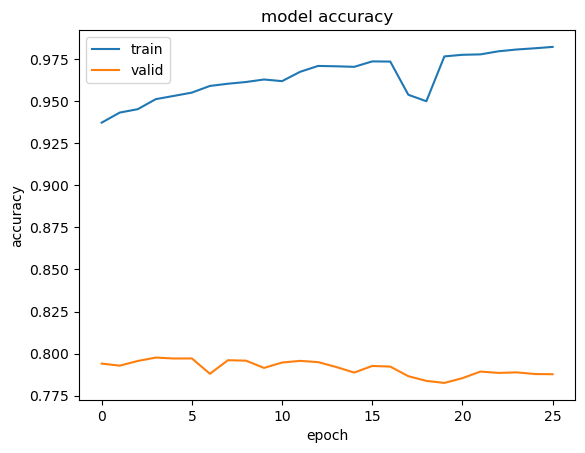

In [ ]:
#plot accuracy and loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


## Maschine Learning

In [65]:
def evaluate_models(x_train_vec, y_train_ml, x_val_vec, y_val_ml, x_test_vec, y_test_ml):
    # Define the models to be compared
    models = [

        ('Ridge Classifier', RidgeClassifier(random_state=187)),
        ('Multinomial Naive Bayes', MultinomialNB()),
        ('Bernoulli Naive Bayes', BernoulliNB()),
        ('Logistic Regression', LogisticRegression(random_state=187, max_iter=10000,n_jobs=-1)),
        ('Decision Tree', DecisionTreeClassifier(random_state=187)),
        ('Gradient Boosting', GradientBoostingClassifier(random_state=187)),
        ('XGBoost', XGBClassifier(random_state=187,n_jobs=-1)),
        ('LightGBM', LGBMClassifier(random_state=187,n_jobs=-1)),
        ('SVM', SVC(kernel='rbf',random_state=187)),
        ('LinearSVC', LinearSVC(random_state=187)),
        ('ExtraTrees', ExtraTreesClassifier(random_state=187,n_jobs=-1)),
        ('PassiveAggressive', PassiveAggressiveClassifier(random_state=187, n_jobs=-1))
        
    ]

    # Create an empty dataframe to store the results
    results_df = pd.DataFrame(columns=['Model', 'Train Score', 'Validation Score', 'Test Score'])

    # Evaluate the models using 5-fold cross-validation
    kfold = KFold(n_splits=5, random_state=187, shuffle=True)
    for name, model in models:
        cv_results = cross_val_score(model, x_train_vec, y_train_ml, cv=kfold, scoring='accuracy', n_jobs=-1)
        train_score = cv_results.mean()
        validation_score = model.fit(x_train_vec, y_train_ml).score(x_val_vec, y_val_ml)
        test_score = model.fit(x_train_vec, y_train_ml).score(x_test_vec, y_test_ml)
        #predict
        y_pred = model.predict(x_val_vec)
        #print classification report
        print(classification_report(y_val_ml, y_pred))
        results_df = pd.concat([results_df, pd.DataFrame([[name, train_score, validation_score, test_score]],
                                                          columns=['Model', 'Train Score', 'Validation Score', 'Test Score'])],
                               ignore_index=True)
        print(f"{name}: Train Score: {train_score:.2f}, Validation Score: {validation_score:.2f}, Test Score: {test_score:.2f}")

    # Return the results dataframe
    return results_df


In [67]:
result_count= evaluate_models(X_train_binary, y_train_ml, X_val_binary, y_val_ml, X_test_binary, y_test_ml)

result_TFID= evaluate_models(x_train_vec, y_train_ml, x_val_vec, y_val_ml, x_test_vec, y_test_ml)

result_hash = evaluate_models(train_x_hashing, y_train_ml, valid_x_hashing, y_val_ml, test_x_hashing, y_test_ml)

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2266
           1       0.78      0.76      0.77      2010

    accuracy                           0.78      4276
   macro avg       0.78      0.78      0.78      4276
weighted avg       0.78      0.78      0.78      4276

Ridge Classifier: Train Score: 0.79, Validation Score: 0.78, Test Score: 0.78
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      2266
           1       0.80      0.73      0.77      2010

    accuracy                           0.79      4276
   macro avg       0.79      0.79      0.79      4276
weighted avg       0.79      0.79      0.79      4276

Multinomial Naive Bayes: Train Score: 0.79, Validation Score: 0.79, Test Score: 0.79
              precision    recall  f1-score   support

           0       0.53      1.00      0.69      2266
           1       1.00      0.00      0.01      2010

    accuracy       

In [ ]:
def plot_model_scores(results_df, title):
    # Sort results dataframe by test score
    results_df = results_df.sort_values(by='Test Score', ascending=False)

    # Plot bar chart of model scores
    results_df.plot(x='Model', y=['Train Score', 'Validation Score', 'Test Score'], kind='bar', figsize=(15, 5), title=title)
    plt.ylim(0.5, 1)
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.grid(axis='y')
    plt.grid(axis='x')
    plt.show()


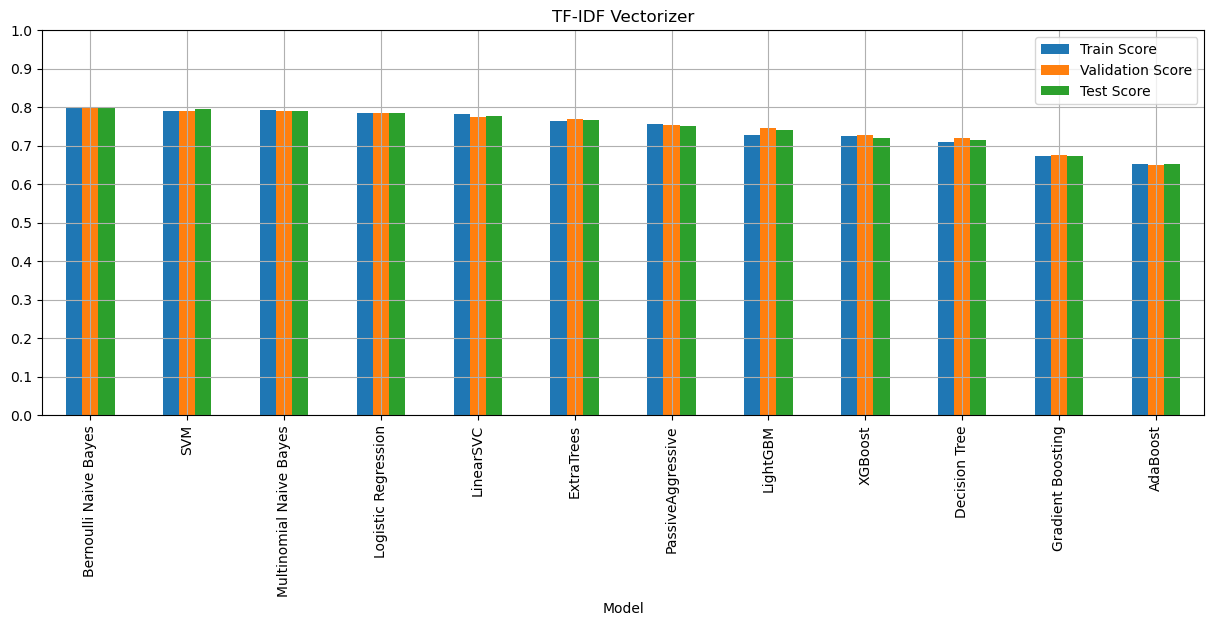

NameError: name 'result_count' is not defined

In [ ]:
plot_model_scores(result_TFID, 'TF-IDF Vectorizer')
plot_model_scores(result_count, 'Count Vectorizer')
plot_model_scores(result_hash, 'Hashing Vectorizer')